# 🌟 Assignment 2. Operation "AI GeoGuessr"

### Deadline: Monday, October 21, 2024, 11:59:00 PM CET (GMT +2)

## 🎯 Mission Overview

The operation consists of two independent missions. Similar to the previous operation, students are required to solve the tasks by achieving the required score and answering the follow-up questions.

## 🧪 Neural Networks and Unsupervised Learning

1. **Mission 2.1 (Supervised Learning)**:

   - Solve a supervised learning problem using a Neural Network (MLP). This is similar to a problem you have worked on before but requires the use of a neural network model.

2. **Mission 2.2 (Unsupervised Learning)**:
   - Given an unlabeled dataset, your task is to cluster similar data points and achieve 100% clustering accuracy. You will not have access to the true labels, but you can verify your cluster assignments using the Kaggle competition provided.

## 📝 Delivery Format (Blackboard)

Please submit **two files**:

1. The completed Jupyter notebook.
2. The solution for the second dataset as a CSV file with two `int` columns: `['ID', 'cluster']`.

## Kaggle details

- Invitation link: https://www.kaggle.com/t/6610d6c6ba314eac9ead0b7a47695700
- Kaggle is a popular platform for data science competitions.
- It allows us to create a Private competition where you can submit your solutions and verify whether you are thinking in the right direction.
- The results of the competition is visible only to the competition participants.
- We will not grade the submissions on Kaggle, we set it up to let you check your clustering.
- You still have to deliver the `.csv` file of the solution and the complete `.ipynb` notebook with discussions and solution code.

> Good luck, comrade!

---


In [1]:
import random
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib.colors import ListedColormap
from numpy import floating
from numpy.typing import NDArray
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import contingency_matrix
from tensorflow import Tensor, Variable
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, History
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

# 🧠 Mission 2.1: Decoding SkyNet's Neural Encryption **(using Neural Networks)**

### 🌐 The Discovery

The dataset consists of the same "Synapse Cipher" data from Assignment 1.

### 🎯 Your Mission

1. Implement a neural network (MLP) using one of the following frameworks: Keras, PyTorch, or TensorFlow.
2. Solve the non-linear problem without manual feature engineering. So the manual feature engineering is not allowed!
3. Predict SkyNet's binary decisions (0 or 1) based on paired signals.
4. Enhance performance by using techniques such as learning rate scheduling, selecting a good optimizer, and fine-tuning training hyperparameters.

> Note: There are no restrictions on the tricks you can use — just achieve the required accuracy. Stack more layers, use AdamW, scheduling, ect. Have fun :)

### 📊 Formal Requirements

1. **Implementation**:

   - Develop a Neural Network using predefined functions/layers.
   - Use one of the popular frameworks: Keras, PyTorch, or TensorFlow.
   - Implement a manual learning rate scheduler with warmup and cosine decay.

2. **Performance**: Achieve at least **0.92** accuracy on the test set.

3. **Discussion**:
   - How did you achieve the reproducibility of the results?
   - Visualize the network's architecture and decision boundary.
   - Which optimizer did you choose? Discuss the differences between the SGD and Adam optimizers.
   - Visualize the learning rate dynamics. Did the learning rate scheduling improve performance? Why or why not?
   - Conduct an ablation study of each architectural and optimization choice concerning test accuracy.


In [2]:
# 1a
SEED = 69_420

random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
data = pd.read_csv("nn_data.csv")
train = data[data["split"] == "train"]
test = data[data["split"] == "test"]

X_columns = [f"x{i}" for i in range(0, 2)]
y_column = "y"

X_train = train[X_columns].to_numpy()
y_train = train[y_column].to_numpy()
X_test = test[X_columns]
y_test = test[y_column]

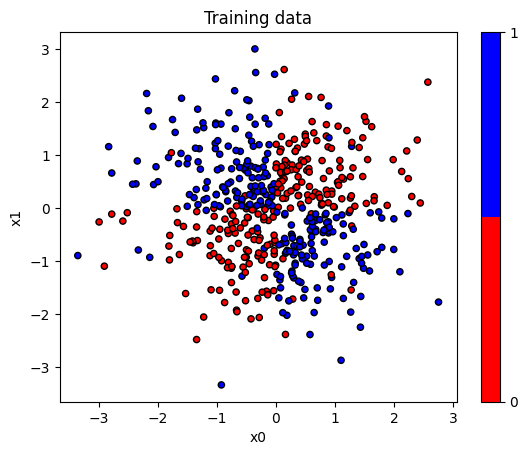

In [4]:
cmap = ListedColormap(("red", "blue"))

plt.scatter(*X_train.T, s=20, c=y_train, cmap=cmap, edgecolors="k")
plt.title("Training data")
plt.xlabel(X_columns[0])
plt.ylabel(X_columns[1])
plt.colorbar(ticks=(0, 1))
plt.show()

In [5]:
models = [
    Sequential(
        [
            InputLayer(input_shape=(2,)),
            Dense(8, activation="relu", name="hidden_layer_1"),
            Dense(1, activation="sigmoid", name="output_layer"),
        ],
        name=f"NeuralNetwork{i}",
    )
    for i in range(1, 5)
]

models[0].summary()

/Users/aleksandervestlund/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "NeuralNetwork1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Could have just used the code from the hint, but did not see it before
# writing this code
class WarmupCosineDecay(LearningRateSchedule):
    def __init__(
        self,
        initial_learning_rate: float,
        target_learning_rate: float,
        decay_steps: int,
        warmup_steps: int,
    ) -> None:
        super().__init__()

        self.initial_learning_rate = initial_learning_rate
        self.target_learning_rate = target_learning_rate
        self.decay_steps = decay_steps
        self.warmup_steps = warmup_steps

    def __call__(self, step: Variable) -> Tensor:
        step = tf.cast(step, tf.float32)
        warmup_percent_done = step / self.warmup_steps
        warmup_lr = self.initial_learning_rate + warmup_percent_done * (
            self.target_learning_rate - self.initial_learning_rate
        )

        decay_step = step - self.warmup_steps
        decay_percent_done = decay_step / self.decay_steps
        cosine_decay = (1 + tf.cos(np.pi * decay_percent_done)) / 2
        decayed_lr = self.target_learning_rate * cosine_decay

        return tf.cond(
            step < self.warmup_steps, lambda: warmup_lr, lambda: decayed_lr
        )


class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch: Any, logs: dict[str, Any]) -> None:
        logs["learning_rate"] = K.get_value(self.model.optimizer.learning_rate)

In [7]:
initial_learning_rate = 0.2
target_learning_rate = 0.3
decay_steps = 1_000
decays = [
    WarmupCosineDecay(
        initial_learning_rate, target_learning_rate, decay_steps, warmup_steps
    )
    for warmup_steps in (50, 0)
]

names = (
    "SGD with warmup",
    "SGD without warmup",
    "Adam with warmup",
    "Adam without warmup",
)
optimizers = [opt(decay) for opt in (SGD, Adam) for decay in decays]
histories: list[History] = []

for model, optimizer in zip(models, optimizers, strict=True):
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=50,
        verbose=0,
        callbacks=[LearningRateLogger()],
    )
    histories.append(history)
    _, accuracy = model.evaluate(X_test, y_test)
    print(f"Accuracy: {accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.9160 - loss: 0.3843
Accuracy: 0.9240
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.9035 - loss: 0.3932
Accuracy: 0.9120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.9017 - loss: 0.3904
Accuracy: 0.9120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.8950 - loss: 0.3696
Accuracy: 0.9080


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


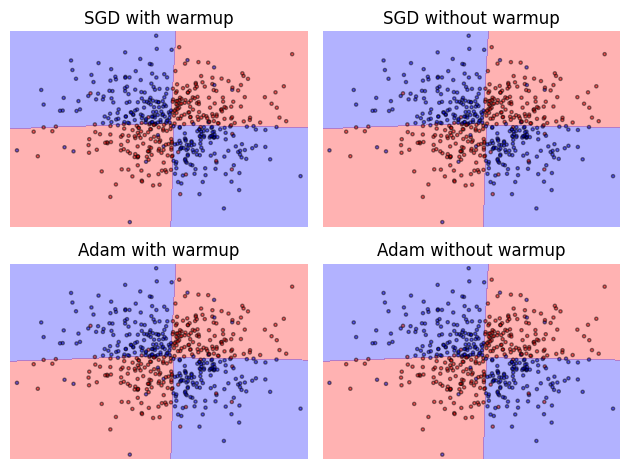

In [8]:
# 1b
margin = 0.15
num = 100
x_min, y_min = np.min(X_train, axis=0) - margin
x_max, y_max = np.max(X_train, axis=0) + margin
x, y = np.meshgrid(
    np.linspace(x_min, x_max, num), np.linspace(y_min, y_max, num)
)

grid = np.stack((x.ravel(), y.ravel()), axis=-1)
z = models[0].predict(grid).reshape(x.shape)

fig, axs = plt.subplots(2, 2)
for ax, model, name in zip(axs.flat, models, names, strict=True):
    ax.contourf(x, y, z, levels=(0, 0.5, 1), cmap=cmap, alpha=0.3)
    ax.scatter(
        *X_train.T, s=5, c=y_train, cmap=cmap, alpha=0.5, edgecolors="k"
    )
    ax.set_title(name)
    ax.axis("off")

plt.tight_layout()
plt.show()

### 1c

The difference between `SGD` and `Adam` optimizers is that `SGD` is a stochastic gradient descent optimizer, while `Adam` is an adaptive learning rate optimization algorithm.
In this task, `SGD` performed better. However, if the hyperparameters are tuned correctly, this may not be the case.


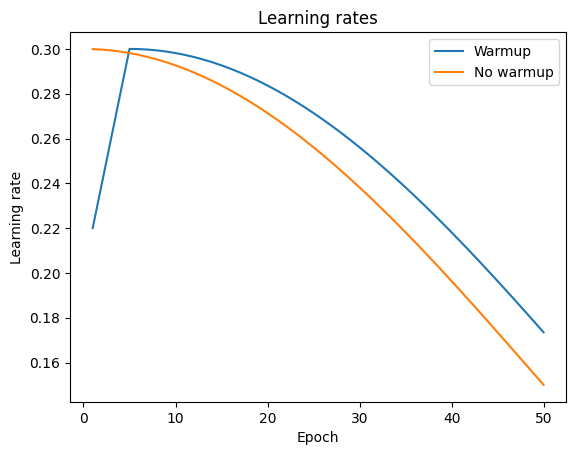

In [9]:
# 1d
warmups = ("Warmup", "No warmup")
epochs = range(1, 51)

for history, name in zip(histories[:2], warmups, strict=True):
    plt.plot(epochs, history.history["learning_rate"], label=name)

plt.title("Learning rates")
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.legend()
plt.show()

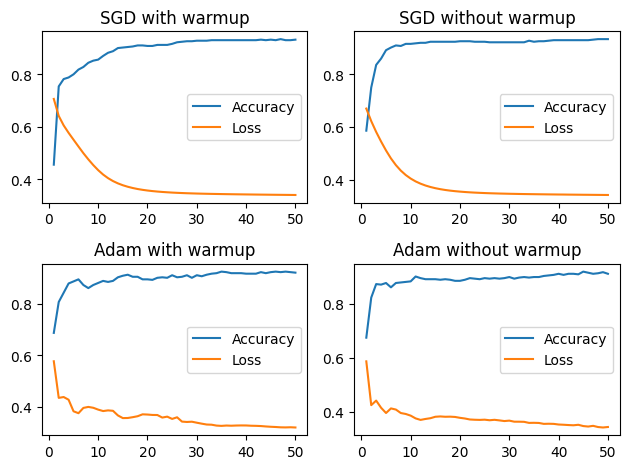

In [10]:
# 1e
fig, axs = plt.subplots(2, 2)

for ax, history, name in zip(axs.flat, histories, names, strict=True):
    ax.plot(epochs, history.history["accuracy"], label="Accuracy")
    ax.plot(epochs, history.history["loss"], label="Loss")
    ax.set_title(name)
    ax.legend()

plt.tight_layout()
plt.show()

# 📶📡🛰️🤳 Mission 2.2: Locate the AI Servers

### 🌐 The Discovery

The NTNU Intelligence team has intercepted encrypted documentation that potentially reveals the locations of AI-compromised servers within Trondheim. Our analysts believe the data contains information about these servers' locations.

However, the number of servers and their exact positions remain unknown. To execute a strategic response, we need to understand the intercepted data and pinpoint the main AI servers.

We have also discovered a vulnerability in the AI's security: it has deployed a clustering verification feature on Kaggle. We can exploit this backdoor to validate our clustering hypotheses.

### 🎯 Your Mission

Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle. When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge

1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.

### 🚀 Your Tools

- The intercepted AI dataset.
- Skills in feature engineering, data manipulation, and visualization.
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts (~30 days \* 50 submissions = 1500 total attempts per student).

> Note: Kaggle competition link — [Kaggle Competition](https://www.kaggle.com/t/6610d6c6ba314eac9ead0b7a47695700)

### 📊 Formal Requirements

1. **Achieve 100% Clustering Accuracy** on Kaggle.

   > Note: The only way to check whether your clustering is correct is to submit it to Kaggle. We do not give you the clusters directly.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.


In [11]:
data = pd.read_csv("unsupervised_data.csv", skiprows=1, header=None)
data.reset_index(drop=False, inplace=True)
data.rename(columns={"index": "ID"}, inplace=True)
data.columns = data.columns.astype(str)

In [12]:
data.info(False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 16385 entries, ID to 16383
dtypes: float64(16384), int64(1)
memory usage: 500.0 MB


In [13]:
tsne = TSNE(3, random_state=SEED, n_jobs=-1)
dbscan = DBSCAN(3, n_jobs=-1)
X_embedded = tsne.fit_transform(data.drop(columns="ID"))
dbscan.fit(X_embedded)

data["cluster"] = dbscan.labels_
data[("ID", "cluster")].to_csv("submission.csv", index=False)

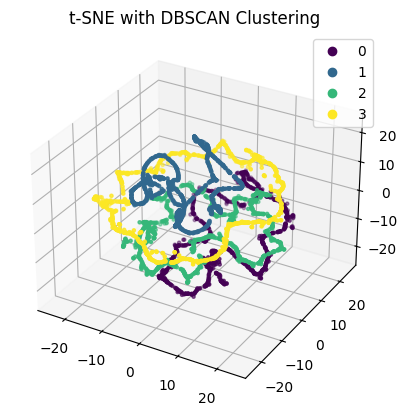

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(*X_embedded.T, s=5, c=dbscan.labels_)
plt.legend(*scatter.legend_elements())
plt.title("t-SNE with DBSCAN Clustering")
plt.show()

### 2a

To determine the correct number of clusters, t-SNE dimensionality reduction was used.
This method was used since it works on non-linearly separable data.
It also works well on data with outliers.
These are the main differences between t-SNE and PCA.
t-SNE uses KL divergence to minimize loss, while UMAP uses cross-entropy loss.


### 2b

The differences between DBSCAN and KMeans are that DBSCAN is a density-based clustering algorithm, while KMeans is a centroid-based clustering algorithm.
KMeans would not work on this dataset since it is not suitable for non-linear data.
This is apparent from the previous plot.


In [15]:
column_names = [
    int(name[4:])  # strip "col_"
    for name in pd.read_csv("unsupervised_data.csv", nrows=0).columns
]
indeces = np.argsort(column_names)

reshaped_data = data.drop(columns="ID").to_numpy()
reshaped_data = reshaped_data[:, indeces]
reshaped_data = reshaped_data.reshape(-1, 128, 128)

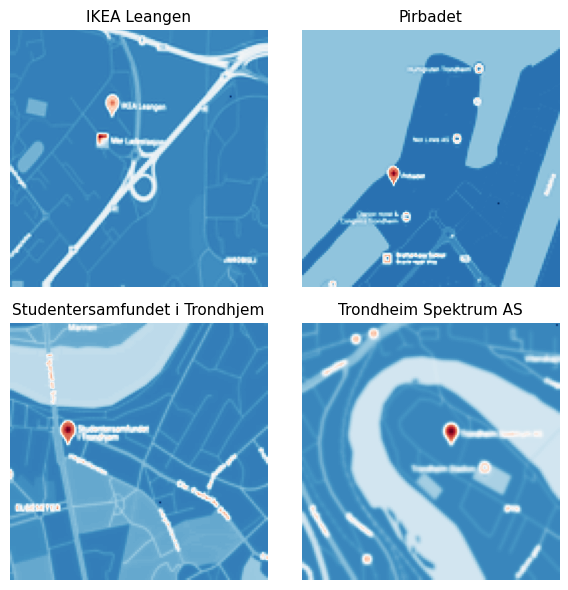

In [16]:
# 2c
pics = {
    "IKEA Leangen": 44,
    "Pirbadet": 117,
    "Studentersamfundet i Trondhjem": 24,
    "Trondheim Spektrum AS": 5,
}
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for ax, (name, idx) in zip(axs.flat, pics.items(), strict=True):
    ax.imshow(reshaped_data[idx], cmap="RdBu")  # RdGy or RdBu
    ax.set_title(name, fontsize=11)
    ax.axis("off")

plt.tight_layout()
plt.show()

### 2d

The hidden data type in the dataset are the server locations as Google Maps images.
Upon sorting the columns and plotting just one image, it was clear how the server locations were encoded.


---

## 🎯 Note: Clustering Accuracy Evaluation


The clustering accuracy metric evaluates how well the predicted clusters match the true clusters, irrespective of the specific labels or names assigned to the clusters.

This means that the evaluation focuses solely on the correct grouping of data points rather than the numerical labels of the clusters themselves.

## Key Characteristics

- **Name-Independent**: The metric cares only about how well the data points are grouped together, not the specific numerical or categorical labels used for the clusters.
- **Focus on Grouping**: The evaluation rewards cluster assignments that correctly group the same data points together, regardless of the specific labels assigned.

### Example

If the true cluster assignments are:

```
[0, 0, 0, 1, 1, 1]
```

and your predicted cluster assignments are:

```
[1, 1, 1, 0, 0, 0]
```

the accuracy will still be **1.0** because the grouping of points is identical, even though the numerical labels are swapped.

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---


In [17]:
def calculate_clustering_accuracy(
    true_labels: NDArray[Any], cluster_labels: NDArray[Any]
) -> floating:
    """Calculate the clustering accuracy between true labels and cluster
    labels.

    The function constructs a contingency matrix between the true labels
    and cluster labels. It then uses the Hungarian algorithm (also known
    as linear sum assignment) to find the best matching between the
    cluster labels and true labels. The clustering accuracy is
    calculated as the number of correctly matched labels divided by the
    total number of labels.

    Args:
        true_labels (NDArray[Any]): An array of true labels for each
            data point.
        cluster_labels (NDArray[Any]): An array of cluster labels
            predicted by a clustering algorithm.

    Returns:
        float: The clustering accuracy, a value between 0 and 1
            representing the proportion of correctly matched labels.

    Example:
        >>> true_labels = np.array([0, 1, 2, 0, 1, 2])
        >>> cluster_labels = np.array([1, 2, 0, 1, 2, 0])
        >>> calculate_clustering_accuracy(true_labels, cluster_labels)
        1.0

    Raises:
        ValueError: If true_labels and cluster_labels are not of the
            same length.
    """
    if true_labels.size != cluster_labels.size:
        raise ValueError(
            "true_labels and cluster_labels must have the same length."
        )

    contingency_mat = contingency_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-contingency_mat)
    correct_pairs = contingency_mat[row_ind, col_ind].sum()
    return correct_pairs / true_labels.size

In [18]:
true_labels = np.array([0, 1, 2, 0, 1, 2])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

1.0

In [19]:
true_labels = np.array([0, 0, 0, 0, 0, 0])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

0.3333333333333333

In [20]:
true_labels = np.array([1, 1, 1, 2, 2, 2])
cluster_labels = np.array([0, 0, 0, 0, 0, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

0.5